In [4]:
using Plots
using FFTW

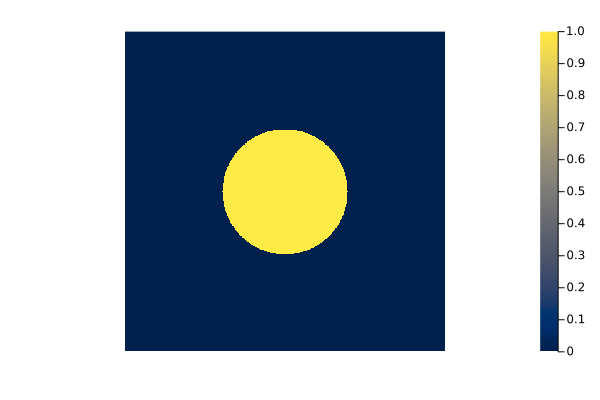

In [8]:
function create_circle_mask(rows, columns,radius)
    y = 1:rows
    x = 1:columns
    center_x = columns ÷ 2
    center_y = rows ÷ 2
    return [ (x - center_x)^2 + (y - center_y)^2 <= radius^2 ? 1 : 0 for y in 1:rows, x in 1:columns ]
end

N=512
radius = 100
mask = create_circle_mask(N,N,radius)
heatmap(mask,aspect_ratio=:equal,c=:cividis,axis=false,grid=false)

In [17]:
typeof(mask), sizeof(mask)

(Matrix{Int64}, 2097152)

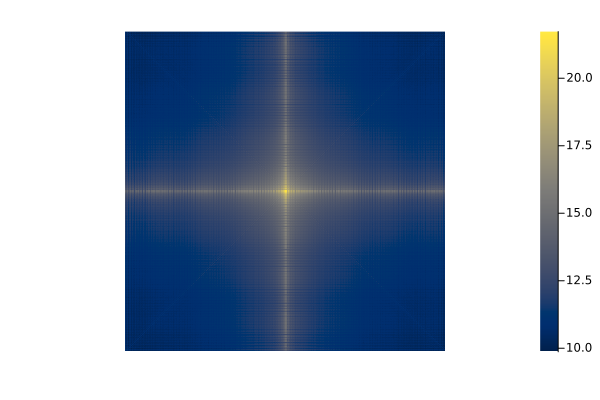

In [22]:
ft_mask = fftshift(fft(mask))
heatmap(log.(abs.(ft_mask)^2),aspect_ratio=:equal,c=:cividis,axis=false,grid=false,zscale=:log10)

In [6]:
function fresnel_propagator(wavefront, z2, λ, pixel, z1=0,method="auto")

    # z2: sample to detector distance in meters 
    # z1: sample to focus distance in meters
    # λ: wavelength in meters 
    # pixel: pixel size of the array in meters

    k = 2*π/λ # wavenumber

    if z1 !=0
        M = (z1+z2)/z1 # set magnification
    else 
        M = 1
    end

    FT_data = fftshift(fft(wavefront))

    if method == "auto" # determines automatically which propagation method to use based on certain conditions
        # do sth
    elseif  method == "transfer_function" # use kernel in real space, i.e. two fourier transforms
        kernel =  fftshift(fft(kernel_real_space))
    else method == "convolution" # use kernel in reciprocal space, i.e. single fourier transform
        kernel = kernel_reciprocal_space
    else method == "ssm" # use method proposed by XXXX to account for curvature and get magnified pixel
        # do sth
    end
    propagated_wave = ifft(FT_data.*kernel)

    return propagated_wave * (1/M)
end

ErrorException: syntax: "if" at /Users/yuri/coding/inscope/julia/propagators.ipynb:18 expected "end", got "else"

In [ ]:
def fresnel_propagator_cone_beam(wavefront, wavelength, pixel_size, sample_to_detector_distance, source_to_sample_distance = 0):

    np = cp.get_array_module(wavefront) # make code agnostic to cupy and numpy
    
    K = 2*np.pi/wavelength # wavenumber
    z2 = sample_to_detector_distance
    z1 = source_to_sample_distance
    
    if z1 != 0:
        M = 1 + (z2/z1)
    else:
        M = 1
    
    FT = np.fft.fftshift(np.fft.fft2(wavefront))

    ny, nx = wavefront.shape
    fx = np.fft.fftshift(np.fft.fftfreq(nx,d = pixel_size/M))#*2*np.pi 2*np.pi factor to calculate angular frequencies 
    fy = np.fft.fftshift(np.fft.fftfreq(ny,d = pixel_size/M))#*2*np.pi
    FX, FY = np.meshgrid(fx,fy)
    # kernel = np.exp(-1j*(z2/M)/(2*K)(FX2+FY*2)) # if using angular frequencies (add 2pi terms for fx, fy above). Formula as in Paganin equation 1.28
    kernel = np.exp(-1j*np.pi*wavelength*(z2/M)(FX2+FY*2)) # if using standard frequencies. Formula as in Goodman, Fourier Optics, equation 4.21

    wave_parallel = np.fft.ifft2(np.fft.ifftshift(FT * kernel))*np.exp(1j*K*z2/M) 

    if z1 != 0:
        # gamma_M = 1 - 1/M
        # y, x = np.indices(wavefront.shape)
        # y = (y - y.shape[0]//2)*pixel_size/M
        # x = (x - x.shape[1]//2)*pixel_size/M
        wave_cone = wave_parallel * (1/M) #* np.exp(1j*gamma_M*K*z2) * np.exp(1j*gamma_M*K*(x*2+y*2)/(2*z2)) # CHECK commented phase terms for complete form of the Fresnel Scaling theorem!
        return wave_cone
    else:
        return wave_parallel